In [1]:
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
from matplotlib import pyplot as plt
import math
from qiskit.circuit import Parameter
from qiskit import Aer, transpile
from scipy.optimize import minimize
from tqdm import tqdm
from qiskit.algorithms.optimizers import ADAM

backend=Aer.get_backend('qasm_simulator')

In [86]:
# function
def qcirc(qubit):
    qr=QuantumRegister(qubit)
    cr=ClassicalRegister(qubit)
    quantumcircuit=QuantumCircuit(qr,cr)
    return quantumcircuit
def measure(circuit):
    for i in range(circuit.num_qubits):
        circuit.measure(i,i)
# featuremap
def ProductFeatureMap(qubit, input):
    qc=qcirc(qubit)
    x=Parameter(f"{input}")
    for i in range(qubit):
        qc.ry(x, i)
    bc=qc.bind_parameters({x:math.asin(input)})
    return bc
def Chebyshev(qubit, input):
    qc=qcirc(qubit)
    x=Parameter(f"{input}")
    for i in range(qubit):
        qc.ry(x,i)
    bc=qc.bind_parameters({x:2*math.acos(input)})
    return bc
def ChebyshevTower(qubit, input):
    qc=qcirc(qubit)
    x=Parameter(f"{input}")
    for i in range(qubit):
        qc.ry((i)*x,i)
        #qc.ry((i+1)*x,i)
    bc=qc.bind_parameters({x:2*math.acos(input)})
    return bc
# Ansatz
def Ansatz(qubit, depth, theta):
    qc=qcirc(qubit)
    for d in range(depth):
        for i in range(qubit):
            qc.rz(theta[3*(i+3*d)],i)
            qc.rx(theta[3*(i+3*d)+1],i)
            qc.rz(theta[3*(i+3*d)+2],i)
    for i in range(0, qubit-1):
        qc.cx(i, i+1)
    return qc
def Ansatz_ad(qubit, depth, theta):
    theta_minus=theta*-1
    theta_minus_rev=list(reversed(theta_minus))
    qc=qcirc(qubit)
    for i in range(qubit-2, -1, -1):
        qc.cx(i, i+1)
    for d in range(depth):
        for i in range(qubit):
            qc.rz(theta_minus_rev[3*(i+3*d)],qubit-1-i)
            qc.rx(theta_minus_rev[3*(i+3*d)+1],qubit-1-i)
            qc.rz(theta_minus_rev[3*(i+3*d)+2],qubit-1-i)
    return qc
# expectation
def circuit_expectation(qubit,counts):
    exp=[]
    for i in range(qubit):
        for j, k in counts.items():
            prob=(k/backend.options.shots)**2
            if j[i]=='0':
                eigenvalue=1
            if j[i]=='1':
                eigenvalue=-1
            exp.append(eigenvalue*prob)
    expectation=sum(exp)
    return expectation
def f(qubit, depth, featuremap, input, backend, theta): 
    qr=QuantumRegister(qubit) 
    cr=ClassicalRegister(qubit)
    qc=QuantumCircuit(qr, cr)
    fm=featuremap(qubit, input)
    feature=qc.compose(fm)
    ansatz=Ansatz(qubit, depth, theta)
    dqc=feature.compose(ansatz)
    dqc.barrier(qr)
    measure(dqc)
    counts=backend.run(transpile(dqc, backend)).result().get_counts()
    fx=circuit_expectation(qubit,counts) 
    return fx
def separate_featuremap(qubit, order, shift, featuremap, input, depth):
    qr=QuantumRegister(qubit)
    cr=ClassicalRegister(qubit)
    qc=QuantumCircuit(qr, cr)
    x=Parameter(f"{input}")
    for i in range(qubit):
        if i==order:
            qc.ry(x+shift,i)
        if i!= order:
            qc.ry(x,i)
    if featuremap==ProductFeatureMap:
        mapping=math.asin(input)
    else:
        mapping=2*math.acos(input)
    bc=qc.bind_parameters({x:mapping})
    return bc, qr
def f_shift_expectation_sum(qubit, shift, featuremap, input, depth, backend, theta):
        f_shift_expectation_sum=[]
        for i in range(qubit):
            qc, qr_1=separate_featuremap(qubit, i, shift, featuremap, input, depth)
            ansatz=Ansatz(qubit, depth, theta)
            dqc=qc.compose(ansatz)
            dqc.barrier(qr_1)
            measure(dqc)
            counts=backend.run(transpile(dqc, backend)).result().get_counts()
            f_shift_expectation_sum.append(circuit_expectation(qubit, counts))
        return sum(f_shift_expectation_sum)
def dfdx(qubit, input, featuremap, depth, backend, theta):
        f_plus=f_shift_expectation_sum(qubit, np.pi/2, featuremap, input, depth, backend, theta)
        f_minus=f_shift_expectation_sum(qubit,-np.pi/2, featuremap, input, depth, backend, theta)
        dfdx=(f_plus-f_minus)*0.5
        return dfdx
# loss
def MSE(a,b):
        mean_square_error=(a-b)**2
        return mean_square_error
def loss(theta, qubit, depth, featuremap, backend, x, Lambda, kappa):
        loss=[]
        for x_i in x:
            fx_i=f(qubit, depth, featuremap, x_i, backend, theta)
            fprimex_i=dfdx(qubit, x_i, featuremap, depth, backend, theta)
            pde_i=fprimex_i+Lambda*fx_i*(kappa+np.tan(Lambda*x_i))
            loss_i=MSE(pde_i, 0)
            loss.append(loss_i)
        total_loss=sum(loss)/len(x)
        print(total_loss)
        return total_loss
intermediate_results=[]
i=[]
i_3=[]
def callback2(theta):
    i_3.append(loss(theta=theta, 
    qubit=6, depth=3, featuremap=ChebyshevTower, backend=backend, x=np.linspace(0,0.9,20), Lambda=8, kappa=0.1))
def optimize(fun, args, tol, iteration):
    loss=[]
    init=np.random.uniform(0.0, 2*np.pi, 3*args[0]*args[1])
    min=minimize(fun=fun, x0=init, args=args, method='BFGS',
                    tol=tol, options={'maxiter':iteration}, 
                    callback=callback2)
    return min
def lbfgsb(fun, args, tol, iteration):
    loss=[]
    init=np.random.uniform(0.0, 2*np.pi, 3*args[0]*args[1])
    min=minimize(fun=fun, x0=init, args=args, method='L-BFGS-B',
                    tol=tol, options={'maxiter':iteration}, 
                    callback=callback2)
    return min
def solution(opt, qubit, depth, featuremap, backend):
    solution_theta=opt.x.tolist()
    x=np.linspace(0,0.9,20).tolist()
    y=[]
    for i in x:
        fxi=f(qubit,depth,featuremap,i,backend,solution_theta)
        y.append(fxi)
    plt.plot(x,y)
    plt.show()
def loss_adam(theta):
    loss=[]
    x=np.linspace(0,0.9,20)
    for x_i in x:
            fx_i=f(qubit=4, depth=2, featuremap=ChebyshevTower, 
                        input=x_i, backend=backend, theta=theta)
            fprimex_i=dfdx(qubit=4, input=x_i, featuremap=ChebyshevTower, 
                            depth=2, backend=backend, theta=theta)
            pde_i=fprimex_i+8*fx_i*(0.1+np.tan(8*x_i))
            loss_i=MSE(pde_i, 0)
            loss.append(loss_i)
    total_loss=sum(loss)/len(x)
    print(total_loss)
    return total_loss

In [133]:
class dqc:
    def __init__(self, qubit, depth, backend, x, Lambda, kappa):
        self.featuremap=self.ChebyshevTower
        self.qubit=qubit
        self.depth=depth
        self.backend=backend
        self.x=x
        self.Lambda=Lambda
        self.kappa=kappa
        self.intermediate_result=[]
    def qcirc(self):
        qr=QuantumRegister(self.qubit)
        cr=ClassicalRegister(self.qubit)
        quantumcircuit=QuantumCircuit(qr,cr)
        return quantumcircuit
    def measure(self, circuit):
        for i in range(circuit.num_qubits):
            circuit.measure(i,i)
    # featuremap
    def ProductFeatureMap(self,input):
        qc=self.qcirc()
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            qc.ry(x, i)
        bc=qc.bind_parameters({x:math.asin(input)})
        return bc
    def Chebyshev(self,input):
        qc=self.qcirc()
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            qc.ry(x,i)
        bc=qc.bind_parameters({x:2*math.acos(input)})
        return bc
    def ChebyshevTower(self, input):
        qc=self.qcirc()
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            qc.ry((i)*x,i)
            #qc.ry((i+1)*x,i)
        bc=qc.bind_parameters({x:2*math.acos(input)})
        return bc
    def Ansatz(self, theta):
        qc=self.qcirc()
        for d in range(self.depth):
            for i in range(self.qubit):
                qc.rz(theta[3*(i+3*d)],i)
                qc.rx(theta[3*(i+3*d)+1],i)
                qc.rz(theta[3*(i+3*d)+2],i)
            for i in range(0, self.qubit-1):
                qc.cx(i, i+1)
        return qc
    def circuit_expectation(self,counts):
        exp=[]
        for i in range(self.qubit):
            for j, k in counts.items():
                prob=(k/self.backend.options.shots)**2
                if j[i]=='0':
                    eigenvalue=1
                if j[i]=='1':
                    eigenvalue=-1
                exp.append(eigenvalue*prob)
        expectation=sum(exp)
        return expectation
    def f(self, input, theta): 
        qr=QuantumRegister(self.qubit) 
        cr=ClassicalRegister(self.qubit)
        qc=QuantumCircuit(qr, cr)
        fm=self.featuremap(input)
        feature=qc.compose(fm)
        ansatz=self.Ansatz(theta)
        dqc=feature.compose(ansatz)
        dqc.barrier(qr)
        self.measure(dqc)
        counts=self.backend.run(transpile(dqc, self.backend)).result().get_counts()
        fx=self.circuit_expectation(counts) 
        return fx
    def separate_featuremap(self, order, shift, input):
        qr=QuantumRegister(self.qubit)
        cr=ClassicalRegister(self.qubit)
        qc=QuantumCircuit(qr, cr)
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            if i==order:
                qc.ry(x+shift,i)
            if i!= order:
                qc.ry(x,i)
        if self.featuremap==self.ProductFeatureMap:
            mapping=math.asin(input)
        else:
            mapping=2*math.acos(input)
        bc=qc.bind_parameters({x:mapping})
        return bc, qr
    def f_shift_expectation_sum(self, shift, input, theta):
            f_shift_expectation_sum=[]
            for i in range(self.qubit):
                qc, qr_1=self.separate_featuremap(order=i, shift=shift, input=input)
                ansatz=self.Ansatz(theta)
                dqc=qc.compose(ansatz)
                dqc.barrier(qr_1)
                self.measure(dqc)
                counts=self.backend.run(transpile(dqc, self.backend)).result().get_counts()
                f_shift_expectation_sum.append(self.circuit_expectation(counts))
            return sum(f_shift_expectation_sum)
    def dfdx(self, input, theta):
            f_plus=self.f_shift_expectation_sum( shift=np.pi/2, input=input, theta=theta)
            f_minus=self.f_shift_expectation_sum(shift=-np.pi/2, input=input, theta=theta)
            dfdx=(f_plus-f_minus)*0.5
            return dfdx
    # loss
    def MSE(self,a,b):
            mean_square_error=(a-b)**2
            return mean_square_error
    def loss(self, theta):
            loss_list=[]
            for x_i in self.x:
                fx_i=self.f(input= x_i, theta=theta)
                fprimex_i=self.dfdx(input=x_i, theta=theta)
                pde_i=fprimex_i+self.Lambda*fx_i*(self.kappa+np.tan(self.Lambda*x_i))
                loss_i=self.MSE(pde_i, 0)
                loss_list.append(loss_i)
            total_loss=sum(loss_list)/len(self.x)
            print(total_loss)
            return total_loss
    def callback2(self,theta):
        self.intermediate_result.append(self.loss(theta=theta))
    def optimize(self, tol, iteration):
        init=np.random.uniform(0.0, 2*np.pi, 3*self.qubit*self.depth)
        min=minimize(fun=self.loss, x0=init, method='BFGS',
                        tol=tol, options={'maxiter':iteration}, 
                        callback=self.callback2)
        return min
    def solution(self, result):
        solution_theta=result.x.tolist()
        x=np.linspace(0,0.9,20).tolist()
        y=[]
        for i in x:
            fxi=self.f(input=i,theta=solution_theta)
            y.append(fxi)
        plt.plot(x,y)
        plt.show()
        

In [134]:
solver5=dqc(qubit=5,depth=3,backend=backend, x=np.linspace(0,0.9,20),Lambda=8, kappa=0.1)

In [135]:
solver5.intermediate_result

[]

In [137]:
result=solver5.optimize(tol=1e-7, iteration=3)

0.873484745663849
1.0042413871271363
1.800083186298151
0.9599791891599301
1.4863044040172937
1.4907464128527708
0.890250708025809
1.4071001823049785
1.2047304778467145
1.45275475125429
0.8265500605905342
1.4164270038469948
1.3842660980266843
0.8322453011517184
1.5726117821939667
1.7985888166190303
1.4509654371937641
1.1093034470612702
1.1736150500644773
1.1417597291882429
1.133776896574875
1.5918596944167929
1.1839868338196118
1.275002614380781
0.9504504019068427
0.8808790496069536
1.0831320865541108
1.5474992742283171
1.0985856999142918
1.2025942660161444
1.329825195047589
1.0584200384719824
0.7078778081523923
1.3289402915031983
1.4447596419540452
1.1698711732822218
1.7644835731929487
0.8705931608280387
1.1707491966948396
1.3742089905864812
1.190810540635892
1.1971342487601502
2.105118706408365
1.171601134608443
1.00276515767712
1.177365555126293
0.5278882792375119
0.46434998171276165
0.4723861130183999
0.7701653376450072
0.5006282094593043
0.3573805860501034
0.7698073238425527
0.3851

In [ ]:
solution5=solver5.solution(result)

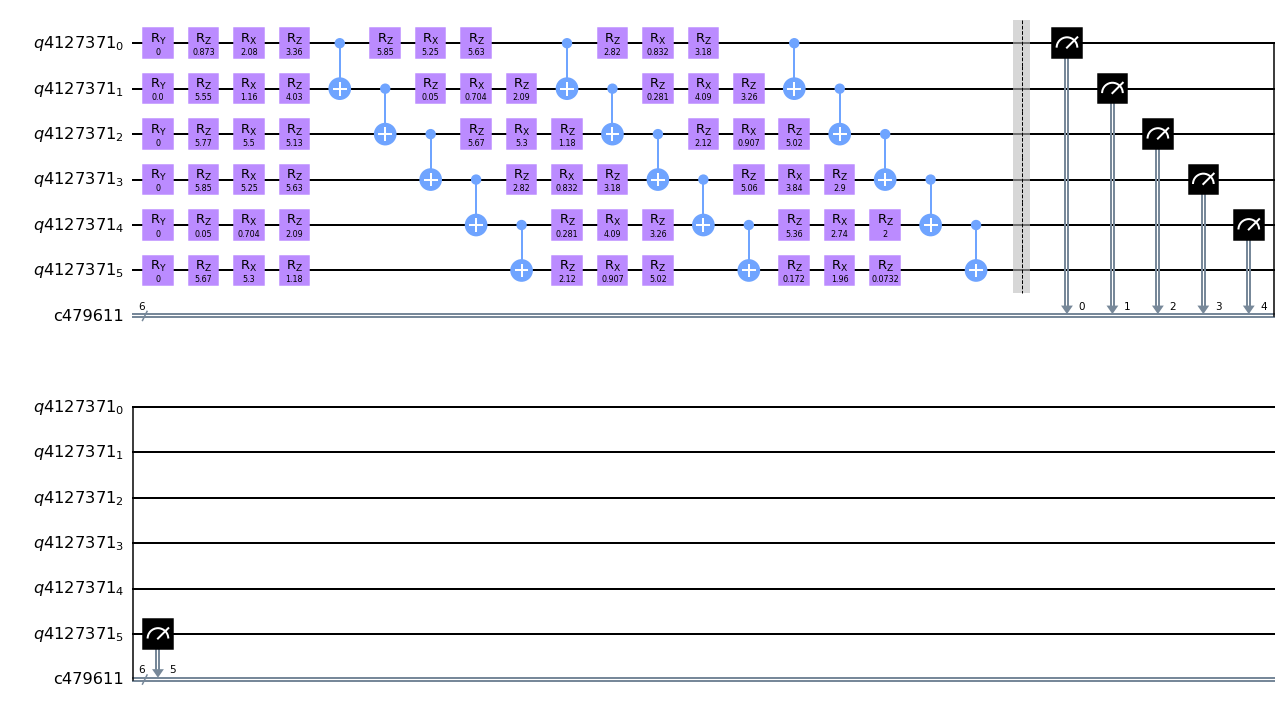

In [130]:
solver3.f(1,np.random.uniform(0,2*np.pi, 54))

In [103]:
result

      fun: 0.6429941430802898
 hess_inv: array([[ 9.37477206e-01,  1.42914484e-01,  2.62298568e-02,
        -4.04773260e-03,  1.52059555e-01,  1.49419182e-01,
         1.63294299e-02, -1.81737512e-02,  1.94627742e-02,
         5.58291753e-02,  3.01351702e-02, -3.28286427e-02,
        -2.23507088e-02,  2.90080439e-02,  2.36080429e-01,
         7.68915186e-02,  1.06862839e-02,  2.06377447e-01,
         4.15285907e-03,  1.26489341e-02,  1.12359231e-01,
         4.36262942e-02,  3.85658636e-01,  2.43002501e-01],
       [ 1.42914484e-01,  9.30192675e-01,  6.90909311e-03,
        -4.08880830e-02, -7.88392798e-02,  3.64267279e-02,
        -6.60142444e-03, -5.04294356e-02, -4.65878222e-02,
         8.06884701e-03, -6.47060799e-03, -1.30533521e-02,
         1.12870083e-01, -4.81346501e-02,  5.26968835e-02,
         1.99217386e-02,  8.62359000e-02, -1.47747172e-01,
        -2.08344334e-03, -5.34839332e-02, -1.14037359e-01,
         3.95372338e-02,  3.69207103e-02,  7.19313679e-02],
       [ 2.62

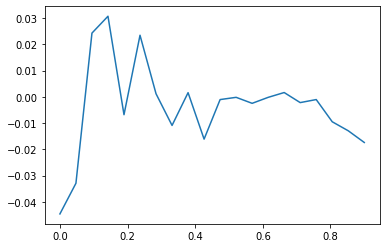

In [102]:
plot=solver3.solution(result)

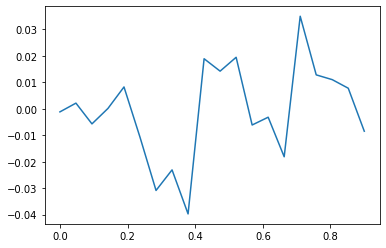

In [68]:
solution(a,4,2,ChebyshevTower,backend)

In [84]:
adam=ADAM(maxiter=2, tol=1e-7, lr=0.001)
a=adam.minimize(fun=loss_adam, x0=np.random.uniform(0,2*np.pi, 24))

3.353336746291526
3.096667015057134
2.8024334882921265
3.4451649124679724
3.0268989611237265
2.8723586600669018
1.751285138283824
2.4951451354819163
2.9084396864244058
2.20686738557806
2.15837087188528
2.5178164661330245
2.668383880581186
2.484127630689024
2.800240773263267
2.2515705367368826
2.6961345356813755
1.8423400577991984
2.628342011559136
2.8031517243976163
1.8715487301057219
2.3073909470464584
2.2668288418565927
2.3803490242214926
3.0851746708528323
2.3597984847858977
2.587012922650719
2.0202368051220096
3.267992782993865
2.7278438829152365
2.103081957787539
2.9388255937692573
2.444039206012794
2.179416760561534
2.9934250301531247
2.8273868031307723
2.262792867363166
2.7424885884319634
2.0940805184161886
2.9188498084449046
2.215265634723848
3.111719838201009
1.9062518128587798
2.9421624312426884
3.034055057642955
2.68363877545364
3.223287745424522
1.6174279127443996
2.563703334874046
2.1201409064734076
3.413553725239955


1. already converged
2. no progress -> to avoid stuck in a local min
3. encounter error 

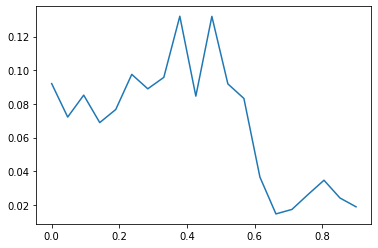

In [47]:
solution(opt,6,3,ChebyshevTower,backend)

In [88]:
i_3

[]

In [87]:
args=(4,2,ChebyshevTower, backend,np.linspace(0,0.9,20),8,0.1)
opt3=optimize(fun=loss, args=args, tol=1e-7, iteration=200)

30.005095166113716
26.246352729827475
52.45221014717184
28.453884353545874
35.09007762407188
27.867697910922868
27.33478802948364
30.350815042598118
30.89372951294619
25.654401223612275
31.51712898388783
28.395633599062258
37.34935102235244
25.592687297649128
31.196349951257627
36.35683483625338
27.133399484942622
29.15103953600869
22.734104999811485
26.207688563240378
30.247615488788064
28.237024927467765
31.92287330205815
24.013272416363897
36.929144350790466
2.0070294301616443
1.269825664125476
1.5874916487975843
4.840267800099828
1.402981379706444
2.386634976399245
1.713514546191734
2.0315115835201936
3.672239995076567
3.531716258265739
3.007405026659385
3.290999275602384
2.6229946536236115
2.1322434230101637
2.4353711942711436
3.5086907043378837
1.7145232593862936
1.533474080013229
5.739164306604526
3.2454372412210395
1.9844824967113504
2.7070958206389135
5.188695581256263
2.48978252385713
4.384076260372156
21.315589160773527
18.907818828703377
18.08453244530709
11.91782715644569


KeyboardInterrupt: 

In [ ]:
args=(6,3,ChebyshevTower, backend,np.linspace(0,0.9,20),8,0.1)
opt=optimize(fun=loss, args=args, tol=1e-4, iteration=200)

6.727556927012283
6.672419023314961
7.441794899759044
8.594375688078708
9.793801631257237
5.233770195948972
7.792391859236557
9.201673902063728
7.711083536753927
8.24178230668153
5.383197294903061
8.42303962487988
6.432255167645645
7.33383809214128
7.744101503267383
7.40845652110025
6.087088370938017
7.351998101259038
8.597630988748811
7.493456011289043
6.286894663598952
8.014592644416416
10.11590566010879
8.7234400319255
8.593336921003367
7.55087142352041
8.123776701783683
8.195507950475841
6.711262759223539
5.654148298012912
7.972815775949835
5.681653839613042
7.3944916155407086
6.932143036213569
8.990479260351684
7.169842851439062
5.908464691095643
5.704149151409636
6.895511882944463
7.264489543849978
12.024068052282054
9.317506972587
6.677646253315254
9.349232884542976
6.068409717378124
8.559945668578212
6.9567107664487455
9.352758575820513
9.98930845680661
7.298761240056851
5.3412578024026605
8.030004658557313
7.044589808216214
8.183907629979293
8.877888432154599
19.25655109015780

In [53]:
args=(6,3,ChebyshevTower, backend,np.linspace(0,0.9,20),8,0.1)
trust_1=lbfgsb(fun=loss, args=args, tol=1e-7, iteration=200)

2.9370162623829392
3.3957051878553726
3.6485044969655873
2.7596905298564725
3.6342559654782916
3.5715278596396116
3.2468364816212003
2.8443169700331192
3.7328850139314342
3.0150951040568286
3.611381937160342
3.075677296397374
3.6352233959155287
4.039910001473834
3.7022322811330435
3.287603220418254
3.3991249973848996
2.790008992802808
4.214254951327297
4.168866937508626
4.8583881344787425
3.718540271496032
3.9481370437357852
3.7970556522575984
3.2384293535547686
2.3714713716873
3.2719280267970148
4.163827274522271
4.449049208017639
3.1640720543240795
3.622950148580773
3.79233141201207
2.5884432959629864
2.7963634083536353
3.362826245807458
4.593010028192192
3.657382327336542
2.930991292693963
3.518792397267217
3.416465357732355
3.32709587789837
3.4697267944853003
3.951906251800408
4.139545182274758
3.6642914955375643
3.4699680941894018
3.57614867305918
4.737348131546442
4.861210203291372
3.6818988261027443
3.207841017650387
3.6863987141557253
4.116180979234182
3.2037011683048213
4.1381

In [76]:
f(6,1,ChebyshevTower,1, backend,np.random.uniform(0,2*np.pi, 18) )

-0.8478221893310547

In [85]:
f_shift_expectation_sum(6, np.pi/2, ChebyshevTower,1,1,backend,np.random.uniform(0, 2*np.pi, 18) )

0.12430572509765625

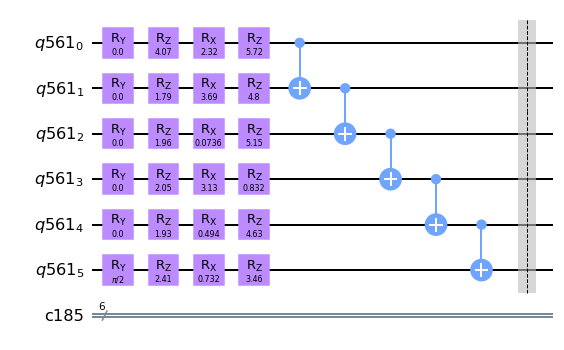

In [ ]:
f_shift_expectation_sum(6, np.pi/2, ChebyshevTower,1,1,backend,np.random.uniform(0, 2*np.pi, 18) )

In [42]:
adam=ADAM(200, 1e-6, 0.01, 0.9,0.9)
adam.minimize(fun=l,x0=np.random.uniform(0,2*np.pi, 45))

100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


263519.6545819403


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


262886.4365513687


100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


263617.7142317629


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


261729.82982454565


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


261176.57793366356


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


260444.4241333905


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


263282.92484627763


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


260067.660503423


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


263283.9155722666


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


262462.1094917104


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


266246.4995757853


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


264393.32237267535


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


262465.80772687925


100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


260761.67478730297


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


262497.1589140784


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


263636.5147216433


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


261069.17399759445


100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


258351.70791725387


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


263400.9017855531


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


260983.98913288428


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


261740.80425580923


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


264798.9123144534


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


261268.6248325658


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


258855.96290084143


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


263037.6695146164


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


263197.0554168573


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


258989.62685068435


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


260888.87607053938


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


266560.1440243988


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


261655.3405912384


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


260423.55108588835


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


260952.61079116506


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


264473.4636538032


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


262686.7574960745


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


264480.02895856486


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


260375.34743912867


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


257638.49510307302


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


261990.17059219006


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


259926.1969748837


100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


261339.3663790258


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


260885.4949029182


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


259299.2889642797


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


259914.97591499603


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


265696.66875915887


100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


260440.76320080893


100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


256146.59271358


100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


262493.8441177679


100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


266367.28645287885


100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


260802.5611522138


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


267084.3955876464


100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


262058.51320942974


100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


261534.27454389533


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


263301.15856850997


100%|██████████| 20/20 [00:13<00:00,  1.54it/s]


262447.88236499636


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


264893.4132418452


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


259750.5614535085


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


261394.97431045288


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


260998.61343032992


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


260178.04648253237


100%|██████████| 20/20 [00:12<00:00,  1.54it/s]


262690.73427025776


100%|██████████| 20/20 [00:12<00:00,  1.54it/s]


256247.3889406782


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


261994.07873506547


100%|██████████| 20/20 [00:13<00:00,  1.54it/s]


265083.97693419893


100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


264637.07493602333


100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


262681.59429372125


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


264065.46508210327


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


263855.33635920717


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


261350.8541566934


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


267243.35967120656


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


258263.99686930282


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


260326.45719597628


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


259635.30641549692


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


257520.8159146555


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


261862.48231729778


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


257607.5714253409


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


264867.799736036


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


263422.36353020975


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


261582.28783420371


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


259363.93503231875


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


259481.02136605713


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


260993.07686126893


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


263299.82097433956


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


259429.66087041952


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


258049.0567855371


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


262796.246947575


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


260726.32520465585


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


260933.85146795478


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


261214.13705614948


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


258171.86182011158


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


264048.91535807156


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


256900.26903430885


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


258110.4046575923


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


259547.05237163036


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


259574.9505092546


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


259067.0148303117


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


262213.9977791751


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


260522.15620871363


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


258531.8049396482


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


258333.26122093797


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


263175.7712376246


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


258817.03560396595


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


263327.3875384611


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


261107.58674611183


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


261927.1047518855


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


255420.14263545876


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


261538.9193213732


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


257597.04284466367


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


261833.1787925583


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


260240.36345826593


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


261376.50626321672


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


260626.24281649492


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


262069.35567411655


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


262771.7453327523


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


260793.00451300334


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


263955.83448962786


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


258345.07799167297


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


258576.16253933316


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


258099.78665127093


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


260536.08087218818


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


263047.29241052934


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


259122.45613509655


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


262440.17854603915


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


257241.74219599896


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


258912.5263587107


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


258676.25718703485


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


260270.07171175155


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


258761.01904745036


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


261842.3721984593


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


261479.36572658567


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


261460.05894224555


100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


258134.767618631


100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


257215.58354595103


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


260060.302773652


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


263767.15231441206


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


259011.09726995858


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


262219.1436775954


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


259489.4267943156


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


260541.26529464583


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


261882.36811941216


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


260011.7942377772


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


263024.08643837913


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


262797.92605169944


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


266989.7612448092


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


261598.78248778038


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


258841.8788746142


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


261992.08223398525


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


261834.42167554004


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


263257.18861672113


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


259032.0495580743


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


257022.245178802


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


263685.3948798388


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


258848.4917282497


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


259795.77363152802


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


259421.04441710873


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


260101.07343528388


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


263444.81754371535


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


261326.8347394371


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


254872.0137107241


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


255791.81947265728


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


261081.4121946764


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


258762.18842648724


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


259839.4764410294


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


261792.03992570197


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


258137.30799267412


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


265113.65593407716


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


263887.5680343282


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


261727.83381141844


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


263866.94270465395


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


258185.33561574566


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


259988.18882151373


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


256945.68823268433


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


256837.59563182513


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


259855.0884972141


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


257571.55227950434


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


258927.85392781688


100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


260573.6995297589


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


256909.6063189411


100%|██████████| 20/20 [00:12<00:00,  1.54it/s]


259422.77321428712


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


255298.84104623244


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


256162.49697546585


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


261488.2320002559


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


259085.53646669458


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


255393.91841238327


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


257716.38829310023


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


256845.68991488963


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


257767.18716817093


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


258795.12311719317


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


259255.59705329346


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


255578.95134173793


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


259570.1329594568


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


257534.1591594162


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


259991.2992343229


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


259208.40377266635


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


260645.8944513333


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


258489.39178752812


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


256065.1526311372


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


256517.5588006673


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


259241.6014931859


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


257269.80205101048


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


256699.414661771


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


255084.76881991257


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


260104.30992056284


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


257977.73023405593


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


260228.94442350016


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


260168.53401719764


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


258626.13223592704


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


258965.82507564678


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


258704.23211294197


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


259254.0113079246


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


260458.34734565616


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


259016.23318721517


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


260257.23242327417


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


261071.48624519855


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


257145.71317634656


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


256843.4510611977


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


255699.49426324913


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


257091.1238746578


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


255574.835269721


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


260872.5768621888


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


259924.80136688217


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


260328.2519484085


100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


263064.8974649


100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


255102.63614850337


 65%|██████▌   | 13/20 [00:10<00:05,  1.27it/s]


KeyboardInterrupt: 

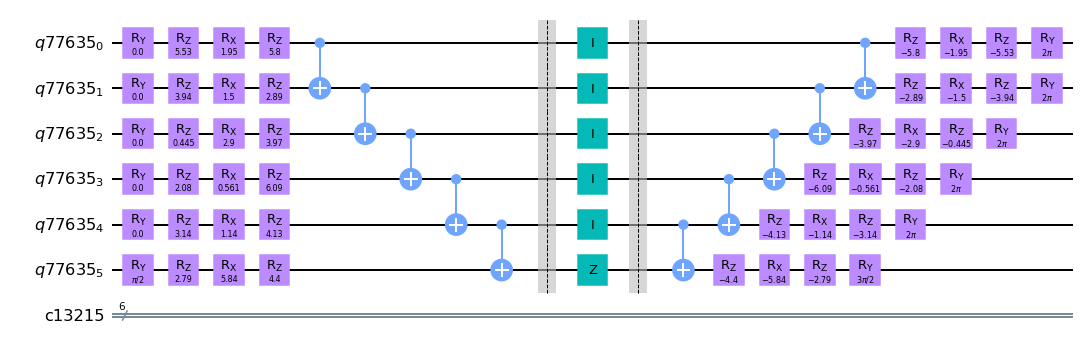

In [27]:
f_shift_expectation_sum(6, np.pi/2, ChebyshevTower,1,1,backend,np.random.uniform(0, 2*np.pi, 18) )

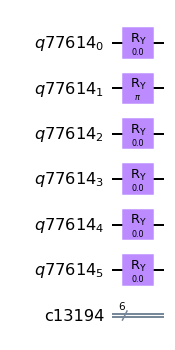

In [25]:
separate_f(6, 1, np.pi, ChebyshevTower, 1,1)[0].draw('mpl')

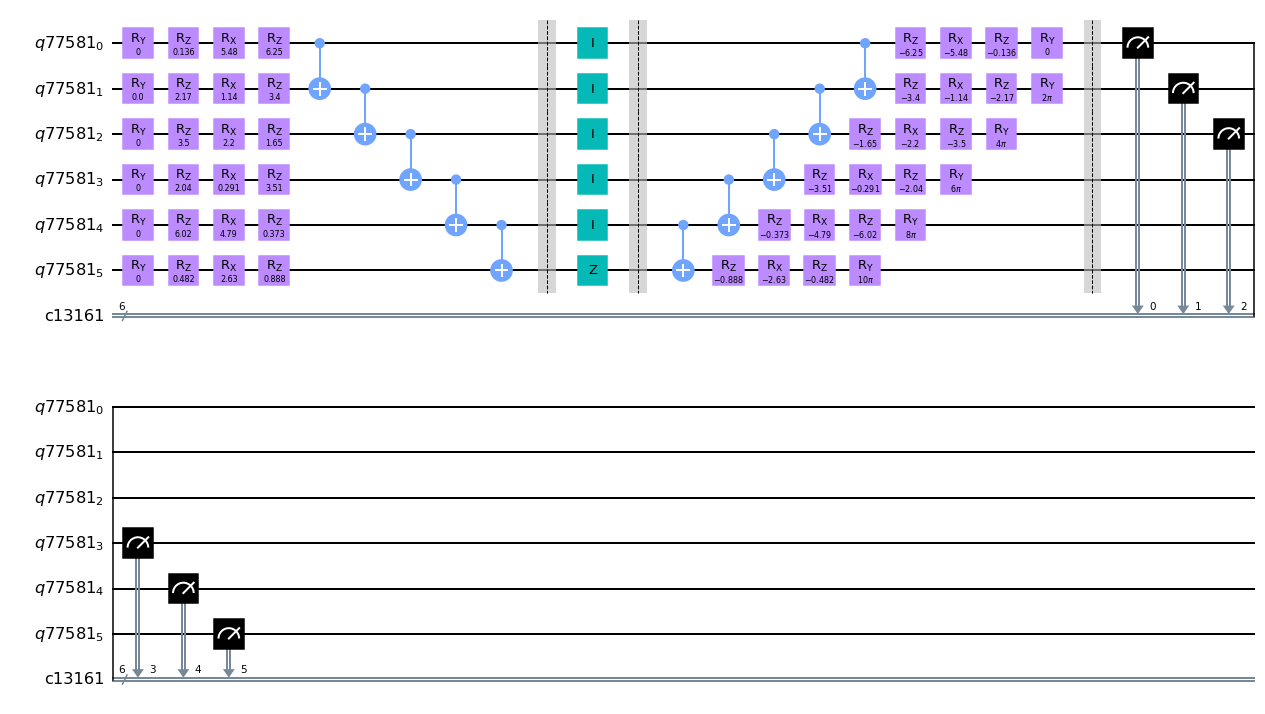

In [14]:
f(6,1,ChebyshevTower, 1, backend, np.random.uniform(0,2*np.pi, 18))